# Manipulating Molecules with RDKit

In this notebook, we load an "ideal" structure for a ligand obtained in the [EC_class_ligands_search](EC_class_ligands_search.ipynb) notebook by pulling coordinates from the PDB and then we manipulate it using RDKit. 

The approach taken here is manual and hands on. We will pick atoms of interest visually, then morph atomic numbers in order to change a carbon atom into a nitrogen atom, and then add a methyl group by changing a hydrogen atom into a carbon atom.

By loading our molecule from an ideal structure with 3D coordinates, we can ensure that we're already near a "good structure" for our manipulated molecules and our geometry optimization will be more likely to succeed.

### Libraries

| Library    | Description     |
| :-----------: | :------------ |
| rdkit | Cheminformatics Toolkit |
| Chem | A subset of rdkit for molecule manipulation |
| IPythonConsole | A subset of rdkit to control image quality |
| Draw | A subset of rdkit for structure drawing |
| AllChem | A subset of rdkit for optimizing 3D structures |

After completing this notebook, if you wish to dig deeper on rdkit, consider reading [Getting Started with rdkit in Python](https://www.rdkit.org/docs/GettingStartedInPython.html).

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

[19:11:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


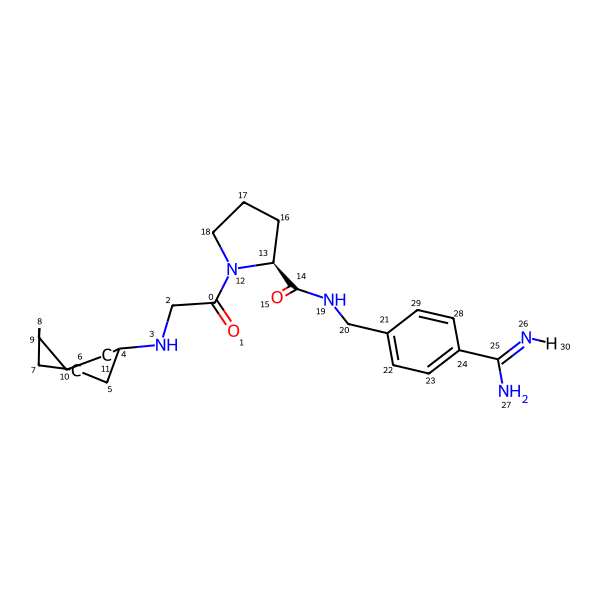

In [13]:
# Configuration for displaying in Jupyter notebooks
IPythonConsole.ipython_useSVG = False  # Use SVG for higher quality images
IPythonConsole.drawOptions.addAtomIndices = True  # Show atom indices
IPythonConsole.molSize = 600,600 # Set size of image

ligand = Chem.MolFromMolFile("ligands/13U_ideal.sdf")
ligand

### Modifying a ligand

We will modify [13U: N-cyclooctylglycyl-N-(4-carbamimidoylbenzyl)-L-prolinamide](https://www.rcsb.org/ligand/13U) from the previous notebook as our starting point to create two additional ligands. In one case, we will substitute nitrogen for carbon in an aromatic ring. In the second case, a carbon will be added to the original aromatic ring. 

Please notice the index numbers attached to each atom in the ligand image generated by the previous cell. This is possible because of an earlier command that we used to display these index numbers. 

`IPythonConsole.drawOptions.addAtomIndices = True  # Show atom indices`

We will use these index numbers to tell the Python code which atoms to modify.

[19:10:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


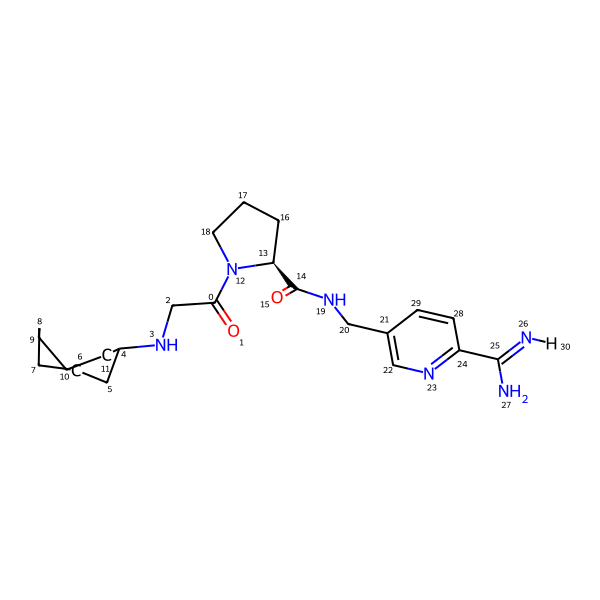

In [12]:
# load a duplicate copy of 13U to manipulate
mod_ligand_N = Chem.MolFromMolFile("ligands/13U_ideal.sdf")

# change carbon in ring to a nitrogen
mod_ligand_N.GetAtomWithIdx(23).SetAtomicNum(7)

mod_ligand_N

Now we'll perform the same operations, but this time add a methyl group to the ring.
In this notebook, we're going to be tricky and morph the hydrogen on the carbon atom to a carbon atom.
However, a more "standard" way to do this would be to create two molecule fragments and then merge them together.
To be consistent with our above approach, we'll do it the tricky way.

[19:12:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


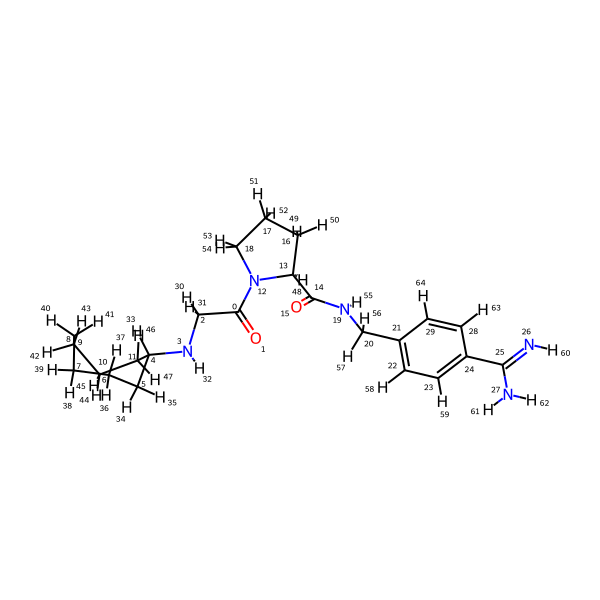

In [15]:
# load another duplicate of the original ligand, but keep the hydrogens

mod_ligand_methyl = Chem.MolFromMolFile("ligands/13U_ideal.sdf", removeHs=False)
mod_ligand_methyl        # This is the original structure. In the cells below, we will convert Hydrogen-59 to a Carbon.

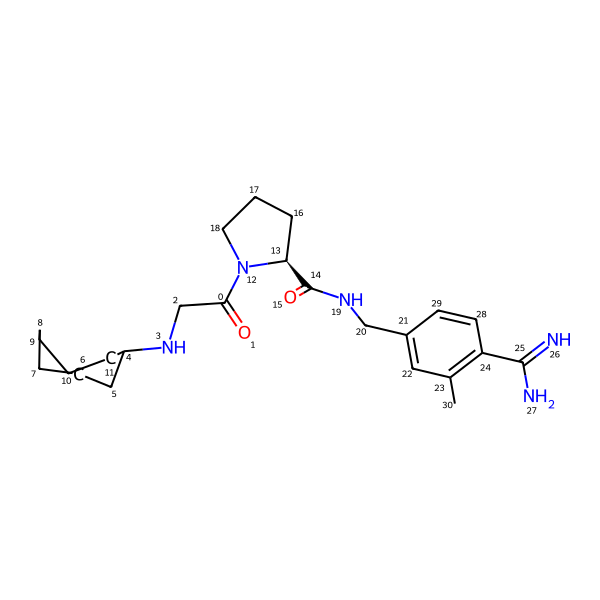

In [16]:
# Use the index number to select the atom we want to change - look at image to see we want to morph atom 59
atom = mod_ligand_methyl.GetAtomWithIdx(59)

atom.SetAtomicNum(6) # Change the atom to carbon
atom.SetNumExplicitHs(3) # Add 3 explicit hydrogens to the carbon

mod_ligand_methyl = Chem.RemoveAllHs(mod_ligand_methyl) # Remove the H's for viewing
mod_ligand_methyl

Now that we have our manipulated molecules, we'll optimize them using RDKit and save them.

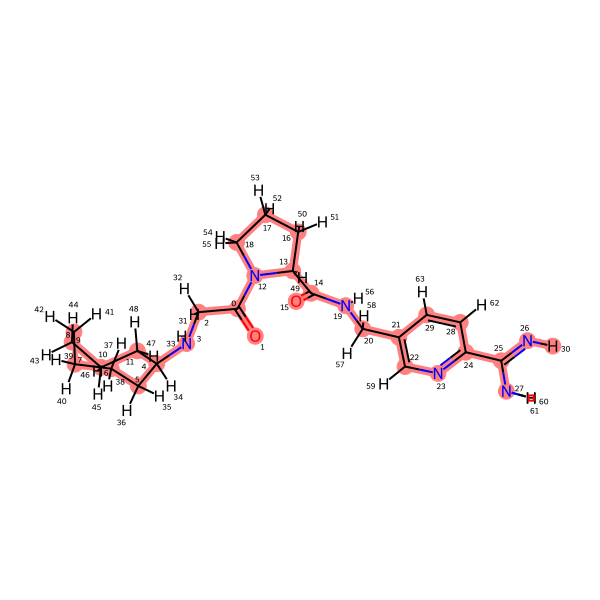

In [19]:
# Optimize new molecules and save
from rdkit.Chem import AllChem

Chem.SanitizeMol(mod_ligand_N)
mod_ligand_NH = Chem.AddHs(mod_ligand_N)

# Do a constrained embedding to keep the ligand in the same position
# this allows for the hydrogens to be added in reasonable locations, but keeps
# the heavy atoms in the same position
# See https://rdkit.org/docs/source/rdkit.Chem.AllChem.html#rdkit.Chem.AllChem.ConstrainedEmbed
constrained_mol = AllChem.ConstrainedEmbed(mod_ligand_NH, mod_ligand_N, useTethers=True)
constrained_mol

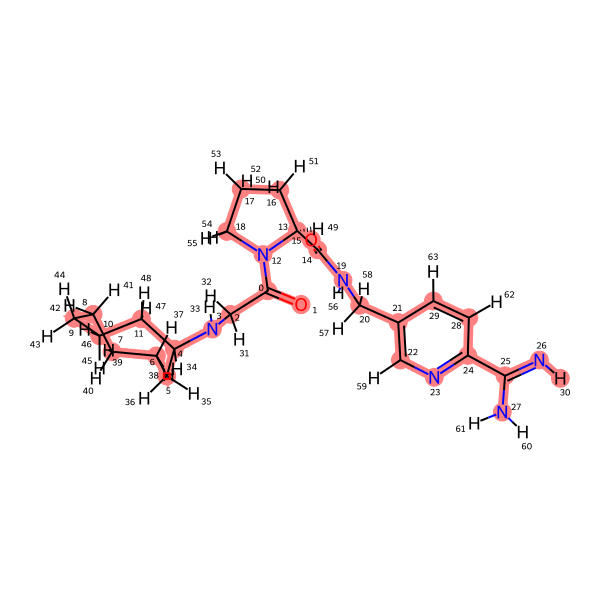

In [20]:
# Perform geometry optimization
opt_N = AllChem.MMFFOptimizeMolecule(mod_ligand_NH)
mod_ligand_NH

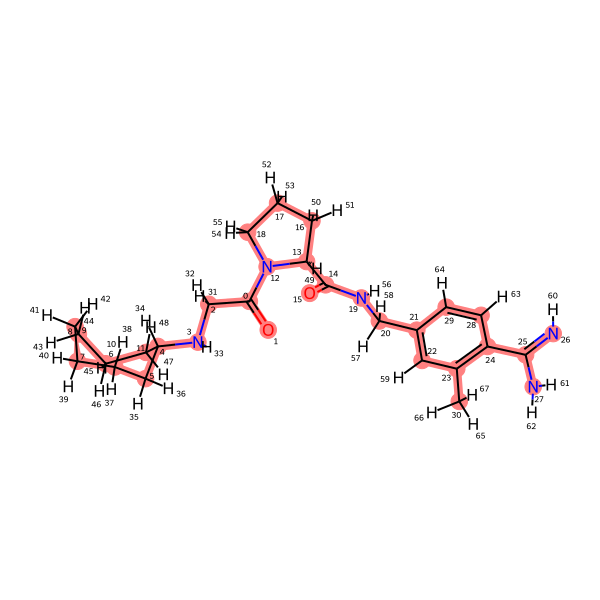

In [21]:
# Repeat process on methyl ligand

Chem.SanitizeMol(mod_ligand_methyl)
mod_ligand_methylH = Chem.AddHs(mod_ligand_methyl)

constrained_mol = AllChem.ConstrainedEmbed(mod_ligand_methylH, mod_ligand_methyl, useTethers=True)
constrained_mol

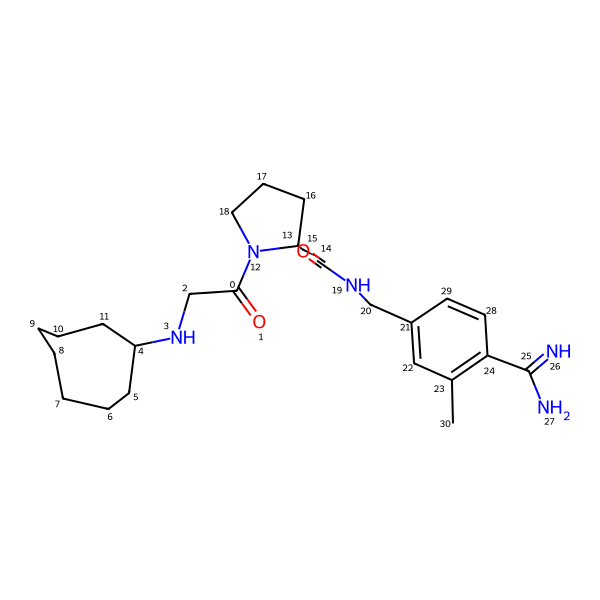

In [22]:
opt_methyl = AllChem.MMFFOptimizeMoleculeConfs(mod_ligand_methylH)
Chem.RemoveAllHs(mod_ligand_methylH)

In [23]:
# save to new files
import os

# make modified ligand directory
os.makedirs("ligands_to_dock", exist_ok=True)

ligand_H = Chem.MolFromMolFile("ligands/13U_ideal.sdf", removeHs=False)

# save modified ligands sdf file - make sure all contain hydrogens and place 
# in a folder of ligands to dock.
Chem.MolToMolFile(ligand_H, 'ligands_to_dock/13U.sdf')
Chem.MolToMolFile(mod_ligand_NH, 'ligands_to_dock/13U_modified_N.sdf')
Chem.MolToMolFile(mod_ligand_methylH, 'ligands_to_dock/13U_modified_methyl.sdf')

[19:23:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
